# Compare all the versions of AVHRR NDVI to MODIS

and then compare their anomalies with Landsat anomalies

In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
from scipy import stats
import xskillscore as xs
import contextily as ctx
import matplotlib as mpl
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from scipy.stats import gaussian_kde
from matplotlib.cm import ScalarMappable
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

## Open datasets

In [ ]:
avhrr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_'+model_var+'_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
avhrr = assign_crs(avhrr, crs=crs)
avhrr.attrs['nodata'] = np.nan

modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)
modis.attrs['nodata'] = np.nan

gimms_pku = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS-PKU_200003_201312.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
gimms_pku = assign_crs(gimms_pku, crs=crs)
gimms_pku.attrs['nodata'] = np.nan

gimms = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS3g_v1.1_1982_2013.nc')['NDVI']
gimms = assign_crs(gimms, crs='epsg:3577')
gimms.attrs['nodata'] = np.nan

trees = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_trees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_nontrees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
merge = xr.where(np.isnan(trees), nontrees, trees)
merge = assign_crs(merge, crs=crs)
merge.attrs['nodata'] = np.nan
merge = merge.rename('NDVI')

avhrr_mask =  ~np.isnan(merge)
del avhrr_mask.attrs['nodata']
avhrr_mask = assign_crs(avhrr_mask, crs=crs)


## Resample datasets to match GIMMS

In [ ]:
avhrr = avhrr.sel(time=slice('2001', '2013'))
modis = modis.sel(time=slice('2001', '2013'))
gimms_pku = gimms_pku.sel(time=slice('2001', '2013'))
gimms = gimms.sel(time=slice('2001', '2013'))
merge = merge.sel(time=slice('2001', '2013'))
avhrr_mask = avhrr_mask.sel(time=slice('2001', '2013'))

avhrr = avhrr.odc.reproject(gimms_pku.odc.geobox, resampling='average')
avhrr = round_coords(avhrr)

gimms = gimms.odc.reproject(gimms_pku.odc.geobox, resampling='average')
gimms = round_coords(gimms)

modis = modis.odc.reproject(gimms_pku.odc.geobox, resampling='average')
modis = round_coords(modis)

merge = merge.odc.reproject(gimms_pku.odc.geobox, resampling='average')
merge = round_coords(merge)

avhrr_mask = avhrr_mask.odc.reproject(gimms_pku.odc.geobox, resampling='mode')
avhrr_mask = round_coords(avhrr_mask)

#lat/lons are off by tiniest amount for some pixels so resample again
# gimms_pku = gimms_pku.odc.reproject(modis.odc.geobox, resampling='nearest')
gimms_pku = round_coords(gimms_pku)

In [ ]:
avhrr = avhrr.where(avhrr_mask)
modis = modis.where(avhrr_mask)
gimms_pku = gimms_pku.where(avhrr_mask)
gimms = gimms.where(avhrr_mask)
merge = merge.where(avhrr_mask)

#pku has some areas masked out
pku_mask = ~np.isnan(gimms_pku)
avhrr = avhrr.where(pku_mask)
modis = modis.where(pku_mask)
merge = merge.where(pku_mask)
gimms = gimms.where(pku_mask)

In [ ]:
# merge.sel(time='2011').plot.imshow(col='time', col_wrap=6, robust=True)

In [ ]:
# gimms.sel(time='2011').plot.imshow(col='time', col_wrap=6, robust=True)

### Timeseries plots


#### per region

In [ ]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [ ]:
mosiac = [
    ["A", "B"],
    ["C", "D"],
    ["E", "F"],
    ["G", "G"],
]

fig, axes = plt.subplot_mosaic(mosiac, figsize=(20,20))

for ax, (index, row) in zip(axes, gdf.iterrows()):
    print(row['region_name'])
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], gimms_pku, crs=crs)
    mask = round_coords(mask)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    modis_region = modis.where(mask)
    avhrr_region = avhrr.where(mask)
    #merge_region = merge.where(mask)
    gimms_pku_region = gimms_pku.where(mask)
    gimms_region = gimms.where(mask)

    avhrr_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR CDR', c ='forestgreen', linewidth=2)
    #merge_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR adjusted (GBM)', c='red', linewidth=2)
    gimms_pku_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR GIMMS-PKU', c='orange', linewidth=2)
    gimms_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR GIMMS3g',c='purple', linewidth=2)
    modis_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='MODIS', c='black', linewidth=2)
    
    axes[ax].set_ylabel('')
    axes[ax].set_xlabel('')
    # axes[ax].sharex(axes['E'])
    axes[ax].tick_params(axis='y', labelsize=15)
    axes[ax].tick_params(axis='x', labelsize=15)
    axes[ax].set_title(row['region_name'], fontsize=20)
    axes[ax].grid(True)

#the last Aus-wide plot
avhrr.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR CDR', c ='forestgreen', linewidth=2)
#merge.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR-Adjusted (GBM)', c='red', linewidth=2)
gimms_pku.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR GIMMS-PKU', c='orange', linewidth=2)
gimms.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR GIMMS3g',c='purple', linewidth=2)
modis.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='MODIS', color='black', linewidth=2)

axes['G'].set_title('Australia', fontsize=20)
axes['G'].legend(fontsize=16)
axes['G'].set_ylabel('')
axes['G'].set_xlabel('')
axes['G'].tick_params(axis='y', labelsize=15)
axes['G'].tick_params(axis='x', labelsize=15)
axes['G'].grid(True)

fig.supylabel(model_var, fontsize=20)    
plt.tight_layout(rect=(0.015,0,1,1))
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compareallproducts_timeseries_bioregion.png',
            bbox_inches='tight', dpi=300);

### Per-pixel error metrics

In [ ]:
modis_mean = modis.mean('time')
low_ndvi_mask = xr.where(modis_mean<0.10,0, 1)

In [ ]:
adjusted_corr = xr.corr(modis, merge, dim='time')
adjusted_corr = adjusted_corr.where(low_ndvi_mask)

orig_corr = xr.corr(modis, avhrr, dim='time')
orig_corr = orig_corr.where(low_ndvi_mask)

adjusted_corr_pku = xr.corr(modis,gimms_pku, dim='time')
adjusted_corr_pku = adjusted_corr_pku.where(low_ndvi_mask)

adjusted_corr_gimms = xr.corr(modis,gimms, dim='time')
adjusted_corr_gimms = adjusted_corr_gimms.where(low_ndvi_mask)

adjusted_rmse_pku = xs.rmse(modis, gimms_pku, dim='time', skipna=True)
adjusted_rmse_pku = adjusted_rmse_pku.where(low_ndvi_mask)

adjusted_rmse_gimms = xs.rmse(modis, gimms, dim='time', skipna=True)
adjusted_rmse_gimms = adjusted_rmse_gimms.where(low_ndvi_mask)

adjusted_rmse = xs.rmse(modis,merge, dim='time', skipna=True)
adjusted_rmse = adjusted_rmse.where(low_ndvi_mask)

orig_rmse = xs.rmse(modis,avhrr, dim='time', skipna=True)
orig_rmse = orig_rmse.where(low_ndvi_mask)

In [ ]:
corr_data = [orig_corr, adjusted_corr_pku, adjusted_corr_gimms, ] #adjusted_corr
products=['AVHRR-CDR', 'AVHRR-GIMMS-PKU','AVHRR-GIMMS3g'] #'AVHRR-adjusted (GBM)'

fig,axes = plt.subplots(1,3, figsize=(16,5), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if n=='Difference':
        cmap='RdBu'
        vmin=-0.5
        vmax=0.5
    else:
        cmap='pink'
        vmin=0
        vmax=1
    im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_title(f'{n} R='"{:.2f}".format(ds.mean().values))
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])

plt.subplots_adjust(wspace=0.075)
cbar = fig.colorbar(im, location='right', ax=axes.ravel().tolist(), fraction=0.05, shrink=0.65)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# cbar.set_label(label=var+' PgC/year', size=15, weight='bold')
cbar.ax.tick_params(labelsize=12)
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compareallproducts_correlation_perpixel.png',
            bbox_inches='tight', dpi=300);

In [ ]:
corr_data = [orig_rmse,  adjusted_rmse_pku, adjusted_rmse_gimms] #adjusted_rmse
products=['AVHRR-CDR', 'AVHRR-GIMMS-PKU','AVHRR-GIMMS3g'] #'AVHRR-adjusted (GBM)'

fig,axes = plt.subplots(1,3, figsize=(16,5), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if model_var=='NDVI':
        if n=='Difference':
            cmap='RdBu'
            vmin=-0.1
            vmax=0.1
        else:
            cmap='YlGnBu_r'
            vmin=0.1
            vmax=0.4
    
    if model_var=='LST':
        if n=='Difference':
            cmap='RdBu'
            vmin=-6
            vmax=6
        else:
            cmap='cividis'
            vmin=0
            vmax=7.0
    im = (ds/modis_mean).plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)   
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f'{n} CV='"{:.2f}".format((ds/modis_mean).mean().values))
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.subplots_adjust(wspace=0.075)
cbar = fig.colorbar(im, location='right', ax=axes.ravel().tolist(), fraction=0.05, shrink=0.65)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# cbar.set_label(label=var+' PgC/year', size=15, weight='bold')
cbar.ax.tick_params(labelsize=12)
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compareallproducts_CV_perpixel.png',
            bbox_inches='tight', dpi=300);

## Residuals through time



In [ ]:
#residuals after harmonization
residual = (modis - merge).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='After harmonization')
residual_sd = (modis - merge).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='After harmonization')

residual_pku = (modis - gimms_pku).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='GIMMS-PKU')
residual_sd_pku = (modis - gimms_pku).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='GIMMS-PKU')

residual_gimms = (modis - gimms).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='GIMMS3g')
residual_sd_gimms = (modis - gimms).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='GIMMS3g')

# residuals before harmonization
residual_b = (modis - avhrr).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='CDR')
residual_sd_b = (modis - avhrr).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='CDR')

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(12,4), sharex=True)

residual_b.plot(ax=ax, legend=False, color='red')
residual_pku.plot(ax=ax, legend=False, color='blue')
residual_gimms.plot(ax=ax, legend=False, color='forestgreen')

ax.axhline(0.0, color='k', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('Average Residuals with MODIS')
ax.set_ylim(-0.125, 0.125)
ax.set_ylabel(model_var+" $_{MODIS}$"+ " - "+model_var+"$_{AVHRR}$", fontsize=13)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

plt.tight_layout()
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compare_residuals.png',
            bbox_inches='tight', dpi=300);

## Anomalies against Landsat

In [6]:
cdr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_'+model_var+'_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
cdr = assign_crs(cdr, crs=crs)
cdr.attrs['nodata'] = np.nan
cdr = cdr.rename('NDVI')

pku = xr.open_dataarray(f'{base}/{model_var}_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc')
# pku = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS-PKU_200003_201312.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
pku = assign_crs(pku, crs=crs)
pku.attrs['nodata'] = np.nan

gimms = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS3g_v1.1_1982_2013.nc')['NDVI']
gimms = assign_crs(gimms, crs='epsg:3577')
gimms.attrs['nodata'] = np.nan

ls = xr.open_dataset(base+'/NDVI_harmonization/Landsat_NDVI_5km_monthly_1988_2012.nc')['NDVI']
ls = assign_crs(ls, crs=crs)
ls.attrs['nodata'] = np.nan

rain = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc').rain
rain = assign_crs(rain, crs=crs)
rain.attrs['nodata'] = np.nan

### Match datasets

In [7]:
pku = pku.sel(time=ls.time)
gimms = gimms.sel(time=ls.time)
rain = rain.sel(time=ls.time)
cdr = cdr.sel(time=ls.time)

ls = ls.odc.reproject(pku.odc.geobox, resampling='average')
cdr = cdr.odc.reproject(pku.odc.geobox, resampling='average')
gimms = gimms.odc.reproject(pku.odc.geobox, resampling='average')
rain = rain.odc.reproject(pku.odc.geobox, resampling='average')

ls = round_coords(ls)
pku = round_coords(pku)
rain = round_coords(rain)
cdr = round_coords(cdr)
gimms = round_coords(gimms)

In [8]:
gimms_mask =  ~np.isnan(gimms)
del gimms_mask.attrs['nodata']
gimms_mask = assign_crs(gimms_mask, crs=crs)

cdr_mask =  ~np.isnan(cdr)
del cdr_mask.attrs['nodata']
cdr_mask = assign_crs(cdr_mask, crs=crs)

pku_mask =  ~np.isnan(pku)
del pku_mask.attrs['nodata']
pku_mask = assign_crs(pku_mask, crs=crs)

ls_mask =  ~np.isnan(ls)
del ls_mask.attrs['nodata']
ls_mask = assign_crs(ls_mask, crs=crs)

#combine masks
mask = (gimms_mask & pku_mask & ls_mask & cdr_mask)
# mask = (pku_mask & ls_mask)

In [9]:
pku = pku.where(mask)
gimms = gimms.where(mask)
rain = rain.where(mask)
cdr = cdr.where(mask)
ls = ls.where(mask)

cdr = cdr.rename({'latitude':'y', 'longitude':'x'})
pku = pku.rename({'latitude':'y', 'longitude':'x'})
ls = ls.rename({'latitude':'y', 'longitude':'x'})
rain = rain.rename({'latitude':'y', 'longitude':'x'})
gimms = gimms.rename({'latitude':'y', 'longitude':'x'})

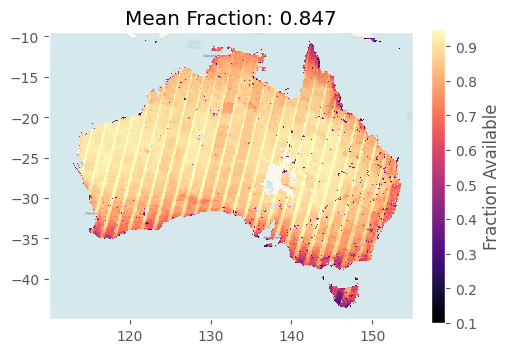

In [10]:
fraction_avail= (~np.isnan(pku)).sum('time')/len(pku.time)

fig,ax=plt.subplots(1,1, figsize=(5,4),sharey=True, layout='constrained')

im = fraction_avail.where(fraction_avail>0).rename('').plot(vmin=0.1, vmax=0.95, ax=ax, cmap='magma', add_labels=False, add_colorbar=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

cb = fig.colorbar(im, ax=ax, shrink=0.75, orientation='vertical', label='Fraction Available');
ax.set_title('Mean Fraction: '+str(round(fraction_avail.where(fraction_avail>0).mean().values.item(), 3)));

### Calculate standardised anomalies

In [11]:
import warnings
warnings.simplefilter('ignore')

#standardized anom
def stand_anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
            ds.groupby("time.month"),
            ds.sel(time=slice('1988', '2012')).groupby("time.month").mean(),
            ds.sel(time=slice('1988', '2012')).groupby("time.month").std()
    )
    
rain_std_anom = stand_anomalies(rain)
pku_std_anom = stand_anomalies(pku)
gimms_std_anom = stand_anomalies(gimms)
ls_std_anom = stand_anomalies(ls)
cdr_std_anom = stand_anomalies(cdr)

### Rolling mean anomalies

In [28]:
roll=12

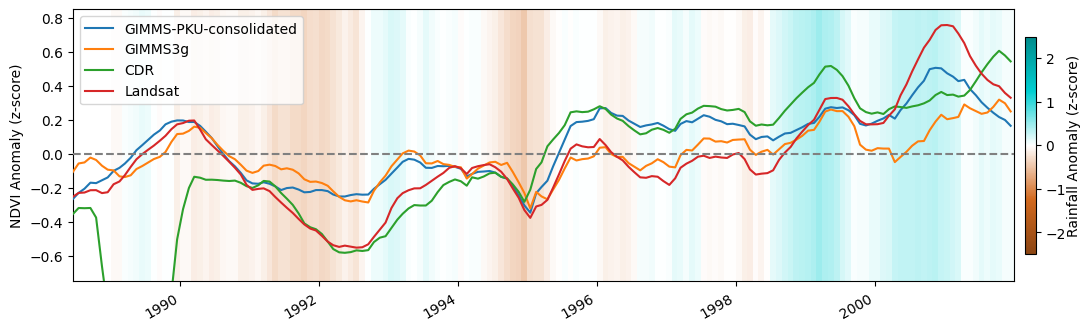

In [30]:
rain_df = rain_std_anom.rename('rain').rolling(time=roll,
                min_periods=6).mean().sel(time=slice('1989','2001')).mean(['x','y']).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax2 = ax.twinx()
#.sel(time=slice('1988','2001'))
pku_std_anom.drop('month').rolling(time=roll, min_periods=6).mean().sel(time=slice('1988','2001')).mean(['x','y']).plot(ax=ax, label='GIMMS-PKU-consolidated')
gimms_std_anom.drop('month').rolling(time=roll, min_periods=6).mean().sel(time=slice('1988','2001')).mean(['x','y']).plot(ax=ax, label='GIMMS3g')
cdr_std_anom.drop('month').rolling(time=roll, min_periods=6).mean().sel(time=slice('1988','2001')).mean(['x','y']).plot(ax=ax, label='CDR')
ls_std_anom.drop('month').rolling(time=roll, min_periods=6).mean().sel(time=slice('1988','2001')).mean(['x','y']).plot(ax=ax, label='Landsat')

norm=plt.Normalize(-2.5,2.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly (z-score)',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)
ax.axhline(0, c='grey', linestyle='--')

# Reformat y-axis label and tick labels
ax.set_ylabel(model_var+' Anomaly (z-score)')
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
ax.set_ylim([-0.75, 0.85]) 
ax.margins(x=0)
ax2.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)
ax.legend()
ax.set_title(None);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Australian_NDVI_compareall_anomalies_landsat_"+str(roll)+"Mrollingmean.png",
            bbox_inches='tight', dpi=300)